In [5]:
# Installing libs

In [6]:
!pip install seaborn
!pip install flask
!pip install flask-ngrok
!pip install flask-cors



In [7]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline


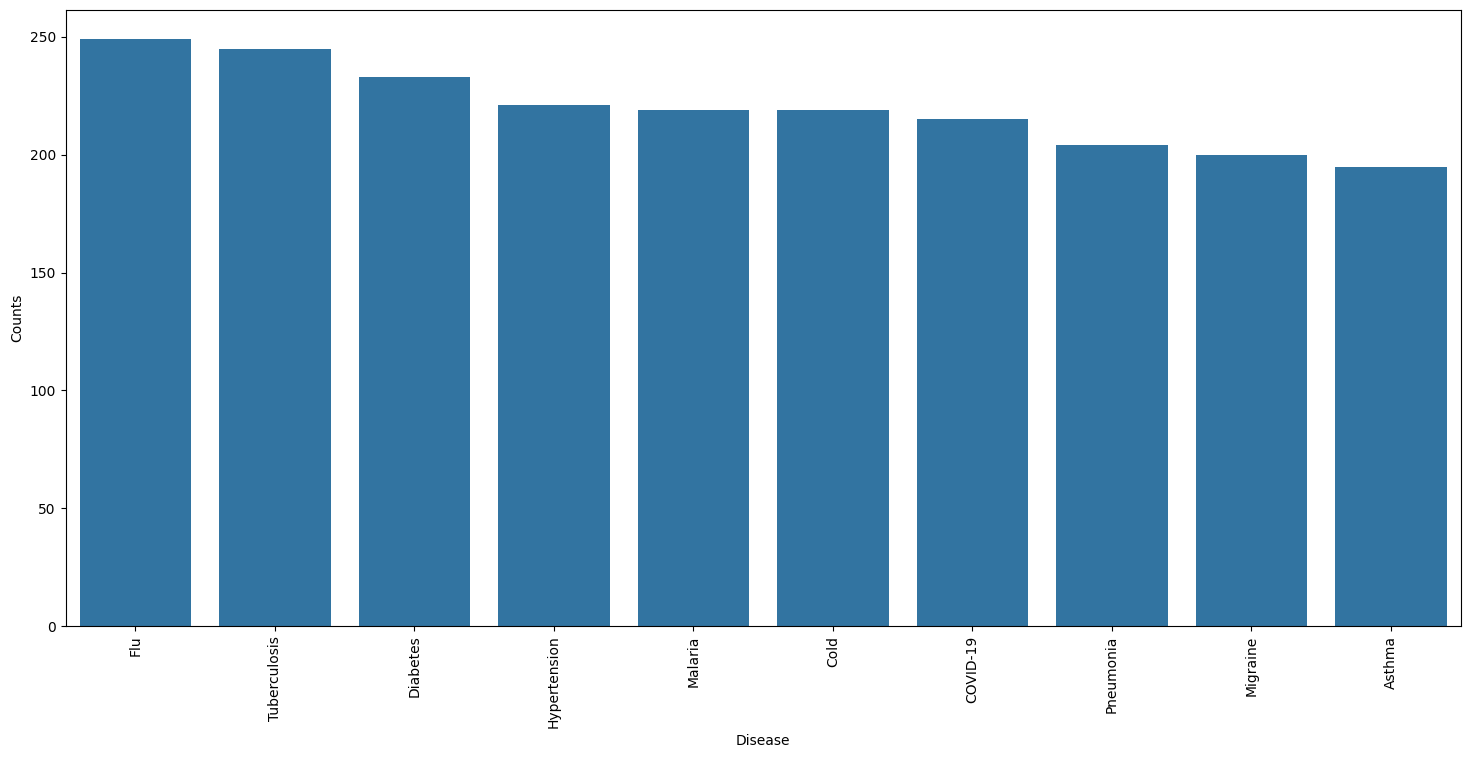

In [8]:
# Reading the train.csv by removing the 
# last column since it's an empty column
DATA_PATH = "Training.csv"
data = pd.read_csv(DATA_PATH).dropna(axis = 1)

# Checking whether the dataset is balanced or not
disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease": disease_counts.index,
    "Counts": disease_counts.values
})

plt.figure(figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()


In [9]:
# Encoding the target value into numerical
# value using LabelEncoder
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])


In [10]:
X = data.iloc[:,:-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test =train_test_split(
  X, y, test_size = 0.2, random_state = 24)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: (1760, 180), (1760,)
Test: (440, 180), (440,)


In [ ]:
# Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

# Initializing Models
models = {
    "SVC":SVC(),
    "Gaussian NB":GaussianNB(),
    "Random Forest":RandomForestClassifier(random_state=18)
}

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, X, y, cv = 10, 
                             n_jobs = -1, 
                             scoring = cv_scoring)
    print("=="*30)
    print(model_name)
    print(f"Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")


SVC
Scores: [0.08636364 0.05454545 0.12272727 0.10909091 0.09545455 0.08636364
 0.09545455 0.07727273 0.10909091 0.11818182]
Mean Score: 0.09545454545454546
Gaussian NB
Scores: [0.07272727 0.06363636 0.1        0.10909091 0.07727273 0.05454545
 0.09090909 0.07272727 0.12272727 0.07272727]
Mean Score: 0.08363636363636363


In [ ]:
# Training and testing SVM Classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)

print(f"Accuracy on train data by SVM Classifier\
: {accuracy_score(y_train, svm_model.predict(X_train))*100}")

print(f"Accuracy on test data by SVM Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for SVM Classifier on Test Data")
plt.show()

# Training and testing Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
preds = nb_model.predict(X_test)
print(f"Accuracy on train data by Naive Bayes Classifier\
: {accuracy_score(y_train, nb_model.predict(X_train))*100}")

print(f"Accuracy on test data by Naive Bayes Classifier\
: {accuracy_score(y_test, preds)*100}")
cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
plt.show()

# Training and testing Random Forest Classifier
rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print(f"Accuracy on train data by Random Forest Classifier\
: {accuracy_score(y_train, rf_model.predict(X_train))*100}")

print(f"Accuracy on test data by Random Forest Classifier\
: {accuracy_score(y_test, preds)*100}")

cf_matrix = confusion_matrix(y_test, preds)
plt.figure(figsize=(12,8))
sns.heatmap(cf_matrix, annot=True)
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()


In [ ]:
# Training the models on whole data
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_svm_model.fit(X, y)
final_nb_model.fit(X, y)
final_rf_model.fit(X, y)

# Reading the test data
test_data = pd.read_csv("Testing.csv").dropna(axis=1)

test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

# Making prediction by take mode of predictions 
# made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)

!pip install scipy
from scipy import stats

final_preds = [stats.mode([i,j,k])[0] for i,j,k in zip(svm_preds, nb_preds, rf_preds)]

print(f"Accuracy on Test dataset by the combined model: {accuracy_score(test_Y, final_preds)*100}")

cf_matrix = confusion_matrix(test_Y, final_preds)
plt.figure(figsize=(12,8))

sns.heatmap(cf_matrix, annot = True)
plt.title("Confusion Matrix for Combined Model on Test Dataset")
plt.show()


In [ ]:
symptoms = X.columns.values

# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom = " ".join([i.capitalize() for i in value.split("_")])
    symptom_index[symptom] = index

data_dict = {
    "symptom_index":symptom_index,
    "predictions_classes":encoder.classes_
}

# Defining the Function
# Input: string containing symptoms separated by commas
# Output: Generated predictions by models
def predictDisease(symptoms):
    symptoms = symptoms.split(",")
    
    # Capitalize each symptom and replace spaces with underscores to match the format in the symptom_index
    symptoms = [symptom.strip().replace(" ", "_").capitalize() for symptom in symptoms]
    
    # Check if all symptoms are valid
    invalid_symptoms = [s for s in symptoms if s not in data_dict["symptom_index"]]
    if invalid_symptoms:
        return {"error": f"Invalid symptoms: {', '.join(invalid_symptoms)}"}
    
    # Proceed with the prediction if all symptoms are valid
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1
        
    input_data = np.array(input_data).reshape(1, -1)
    
    # Generating individual predictions from the models
    rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
    nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
    svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
    
    final_prediction = statistics.mode([rf_prediction, nb_prediction, svm_prediction])
    
    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": svm_prediction,
        "final_prediction": final_prediction
    }
    return predictions

# Testing the function
print(predictDisease("Itching,Skin Rash,Nodal Skin Eruptions"))

In [ ]:
import numpy as np
import statistics

def predictDisease(symptoms):
    symptoms = symptoms.split(",")
    
    # Capitalize and format symptoms to match symptom_index
    symptoms = [symptom.strip().replace(" ", "_").capitalize() for symptom in symptoms]
    
    # Debugging: Check what symptoms are being processed
    print(f"Processing symptoms: {symptoms}")
    
    # Check if all symptoms are valid
    invalid_symptoms = [s for s in symptoms if s not in data_dict["symptom_index"]]
    if invalid_symptoms:
        return {"error": f"Invalid symptoms: {', '.join(invalid_symptoms)}"}
    
    # Proceed with the prediction if all symptoms are valid
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1
        
    input_data = np.array(input_data).reshape(1, -1)
    
    # Debugging: Check if the input_data is valid
    print(f"Input data for model prediction: {input_data}")
    
    # Generating individual predictions from the models
    try:
        rf_prediction = data_dict["predictions_classes"][final_rf_model.predict(input_data)[0]]
        nb_prediction = data_dict["predictions_classes"][final_nb_model.predict(input_data)[0]]
        svm_prediction = data_dict["predictions_classes"][final_svm_model.predict(input_data)[0]]
        
        # Debugging: Print model predictions
        print(f"Model predictions: RF: {rf_prediction}, NB: {nb_prediction}, SVM: {svm_prediction}")
        
        # Take the mode of all predictions for the final prediction
        final_prediction = statistics.mode([rf_prediction, nb_prediction, svm_prediction])
        
        predictions = {
            "rf_model_prediction": rf_prediction,
            "naive_bayes_prediction": nb_prediction,
            "svm_model_prediction": svm_prediction,
            "final_prediction": final_prediction
        }
        return predictions
    
    except Exception as e:
        # If any error occurs during prediction, return the error message
        return {"error": str(e)}


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_most_similar_symptoms(input_symptoms):
    """Finds the closest available symptoms using cosine similarity."""
    input_embeds = get_symptom_embeddings(input_symptoms)
    similarities = cosine_similarity(input_embeds, symptom_embeddings)
    closest_symptoms = [AVAILABLE_SYMPTOMS[idx] for idx in similarities.argmax(axis=1)]
    return closest_symptoms

def predictDisease(symptoms):
    symptoms = symptoms.split(",")
    
    # Find the closest match for each symptom
    matched_symptoms = get_most_similar_symptoms(symptoms)
    
    input_data = [0] * len(AVAILABLE_SYMPTOMS)
    for symptom in matched_symptoms:
        index = AVAILABLE_SYMPTOMS.index(symptom)
        input_data[index] = 1

    input_data = np.array(input_data).reshape(1, -1)

    # Generate individual predictions from models
    rf_prediction = final_rf_model.predict(input_data)[0]
    nb_prediction = final_nb_model.predict(input_data)[0]
    svm_prediction = final_svm_model.predict(input_data)[0]

    # Majority voting for final prediction
    final_prediction = statistics.mode([rf_prediction, nb_prediction, svm_prediction])

    predictions = {
        "rf_model_prediction": rf_prediction,
        "naive_bayes_prediction": nb_prediction,
        "svm_model_prediction": svm_prediction,
        "final_prediction": final_prediction
    }
    return predictions


In [ ]:
import os
import joblib
import streamlit as st
from model import DiseasePredictor
from nlp_processor import SymptomExtractor
from symptoms import AVAILABLE_SYMPTOMS

# Suppress oneDNN warnings
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Ensure model exists
MODEL_PATH = "rf_model.pkl"
if not os.path.exists(MODEL_PATH):
    predictor = DiseasePredictor()
    predictor.train("Training.csv")
    joblib.dump(predictor, MODEL_PATH)

# Load models efficiently
@st.cache_resource(show_spinner=True)
def load_models():
    try:
        predictor = joblib.load(MODEL_PATH)
        extractor = SymptomExtractor()
        return predictor, extractor
    except Exception as e:
        st.error(f"Error loading models: {e}")
        return None, None

def main():
    st.set_page_config(page_title="Disease Prediction System", page_icon="generated-icon.png")
    
    # UI Layout
    col1, col2 = st.columns([1, 5])
    with col1:
        st.image("generated-icon.png", width=80)
    with col2:
        st.title("Disease Prediction System")

    predictor, extractor = load_models()
    if predictor is None or extractor is None:
        st.error("Models failed to load. Please check logs.")
        return

    # Initialize session state
    if 'confirmed_symptoms' not in st.session_state:
        st.session_state.confirmed_symptoms = set()
    if 'messages' not in st.session_state:
        st.session_state.messages = []

    # Display chat history
    for message in st.session_state.messages:
        with st.chat_message(message["role"]):
            st.write(message["content"])
    
    prompt = st.chat_input("Describe your symptoms")
    if prompt:
        st.session_state.messages.append({"role": "user", "content": prompt})
        with st.chat_message("user"):
            st.write(prompt)
        
        extracted_symptoms = extractor.extract_symptoms(prompt, predictor.symptom_index)
        st.write(f"Extracted symptoms: {extracted_symptoms}")
        
        if not extracted_symptoms:
            response = "No symptoms recognized. Please try again."
        else:
            st.session_state.confirmed_symptoms.update(extracted_symptoms)
            response = "Identified symptoms:\n" + "\n".join([f"- {s}" for s in extracted_symptoms])
        
        with st.chat_message("assistant"):
            st.write(response)
        st.session_state.messages.append({"role": "assistant", "content": response})
        
        if len(st.session_state.confirmed_symptoms) >= 3:
            diseases, confidences = predictor.predict(list(st.session_state.confirmed_symptoms))
            result = "Top 3 Predictions:\n" + "\n".join(
                [f"{i+1}. {disease} ({confidence:.1f}%)" for i, (disease, confidence) in enumerate(zip(diseases, confidences))]
            )
            
            st.session_state.messages.append({"role": "assistant", "content": result})
            st.write(result)
            if confidences[0] < 50:
                st.write("Low confidence. Please consult a doctor.")
    
    if st.button("Clear All"):
        st.session_state.confirmed_symptoms.clear()
        st.session_state.messages = []
        st.rerun()

if __name__ == "__main__":
    main()


In [ ]:
@app.route('/users', methods=['POST'])
def get_users():
    try:
        request_data = request.get_json()
        if not request_data or 'symptoms' not in request_data:
            return jsonify({"error": "Invalid input. 'symptoms' field is required."}), 400

        symptoms = request_data['symptoms']
        data = predictDisease(symptoms)
        return jsonify(data), 200

    except Exception as e:
        return jsonify({"error": str(e)}), 500


In [ ]:
from flask import Flask, jsonify, request
from flask_ngrok import run_with_ngrok
from flask_cors import CORS

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)

@app.route('/users', methods=['POST'])
def get_users():
    try:
        
        request_data = request.get_json()
        
        if not request_data or 'symptoms' not in request_data:
            return jsonify({"error": "Invalid input. 'symptoms' field is required."}), 400
        
        symptoms = request_data['symptoms']
        app.logger.info("Received symptoms: %s", symptoms)
        
        
        data = predictDisease(symptoms)
        return jsonify(data), 200

    except Exception as e:
        return jsonify({"error": str(e)}), 500

# Start Flask app
if __name__ == '__main__':
    app.run()